In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygeostat as gs

print("pygeostat version:", gs.__version__)

pygeostat version: 1.1.0


In [2]:
# import Outlier class from outlier.py
from outlier import Outlier

In [3]:
example = "ex3"
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures")
os.makedirs(IMAGES_PATH, exist_ok=True)


def savefig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Load Data

In [4]:
comps = gs.DataFile("largedata.dat", x="X", y="Y", z="Z")
comps.data = comps.data.dropna()
comps.head()

,ID,X,Y,Z,Cu,Mo
0,1.0,36226.0,27295.1,803.75,0.14963,0.00923
1,1.0,36226.0,27295.1,813.75,0.13375,0.00100
2,1.0,36226.0,27295.1,823.75,0.06790,0.00153
3,1.0,36226.0,27295.1,833.75,0.01683,0.00156
4,1.0,36226.0,27295.1,843.75,0.13758,0.01003


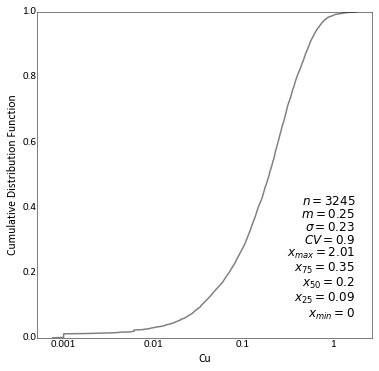

In [5]:
gs.histogram_plot(comps, "Cu", icdf=1, logx=True, figsize=(6, 6))

Saving figure outlier_ex3_drillplot


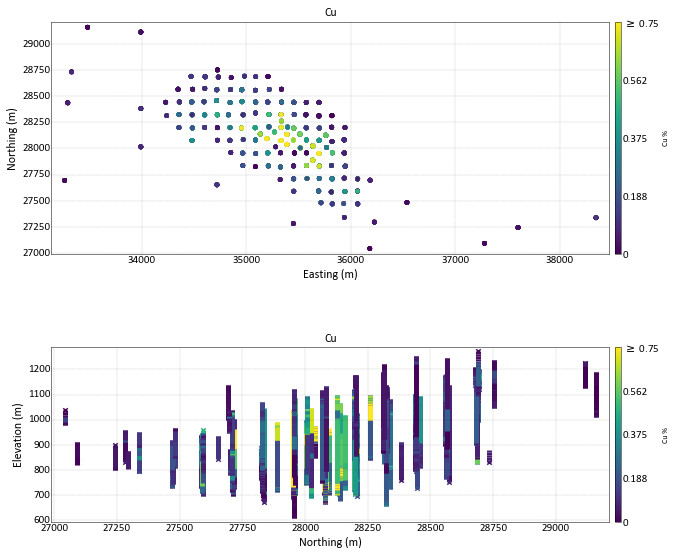

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
gs.location_plot(
    comps,
    var="Cu",
    orient="xy",
    vlim=(0, 0.75),
    ax=ax[0],
    cbar_label="Cu %",
    grid=True,
)
gs.location_plot(
    comps,
    var="Cu",
    orient="yz",
    vlim=(0, 0.75),
    ax=ax[1],
    cbar_label="Cu %",
    grid=True,
)
savefig(f"outlier_{example}_drillplot", tight_layout=False)

# Decluster

In [7]:
declus = gs.Program("declus", getpar=True)

D:\03 UofA\04 Research\02 PhD\Code\Outlier Class\tmp1przt57n/declus.par has been copied to the clipboard


In [8]:
parstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
largedata.dat         -file with data
2   3   4   5               -  columns for X, Y, Z, and variable
-998     1.0e21          -  trimming limits
declus.sum                  -file for summary output
declus.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
50  250  2500               -number of cell sizes, min size, max size
50                           -number of origin offsets
"""
declus.run(parstr=parstr, liveoutput=False)

Calling:  ['declus', 'temp']


In [9]:
sum_fl = gs.DataFile("declus.sum")

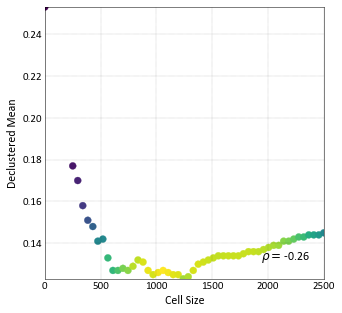

In [10]:
gs.scatter_plot(
    sum_fl["Cell Size"], sum_fl["Declustered Mean"], grid=True, figsize=(5, 5)
)

In [11]:
parstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
largedata.dat         -file with data
2   3   4   5               -  columns for X, Y, Z, and variable
-998     1.0e21          -  trimming limits
declus.sum                  -file for summary output
declus.out                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
1  500  500               -number of cell sizes, min size, max size
50                          -number of origin offsets
"""
declus.run(parstr=parstr, liveoutput=False)

Calling:  ['declus', 'temp']


In [12]:
comps = gs.DataFile("declus.out").data.rename(
    columns={"Declustering Weight": "wts"}
)
comps.describe()

,ID,X,Y,Z,Cu,Mo,wts
count,3245.000000,3245.000000,3245.000000,3245.000000,3245.00000,3245.000000,3245.000000
mean,68.516179,35264.431464,28160.878243,913.787532,0.25328,0.011527,1.000000
std,35.551652,593.326564,340.973183,124.160618,0.22901,0.022745,1.791917
min,1.000000,33260.300000,27041.900000,609.187500,0.00075,0.000010,0.166873
25%,39.000000,34849.600000,27957.100000,819.187500,0.08855,0.001620,0.286027
50%,69.000000,35337.000000,28196.100000,898.412500,0.19575,0.004230,0.446302
75%,98.000000,35695.800000,28441.900000,1002.013000,0.34877,0.012780,0.808846
max,136.000000,38348.800000,29160.100000,1272.337000,2.00971,0.483500,15.808354


# Despike

In [13]:
despike = gs.Program("despike_2000", getpar=True)

D:\03 UofA\04 Research\02 PhD\Code\Outlier Class\tmpluxfb2tn/despike_2000.par has been copied to the clipboard


In [14]:
parstr = """                  Parameters for Despike_2000
                  ***************************

START OF PARAMETERS:
declus.out                   -file with data
2   3   4   5    0                -columns for X, Y, Z, Var, and rock type
0  0  0                      -number valid RTs and their integer codes
-998   1.0e21             -trimming limits
10                           -number of NN for local average
0.5                          -Weight W1 for random component (between [0-1])
69069                        -Random Seed
despike.out                  -file for output
"""
despike.run(parstr, liveoutput=False)

Calling:  ['despike_2000', 'temp']


In [15]:
comps = gs.DataFile("despike.out").data.rename(
    columns={"Declustering Weight": "wts"}
)
comps["length"] = 10.0
comps.head()

,ID,X,Y,Z,Cu,Mo,wts,DS-Cu,length
0,1.0,36226.0,27295.1,803.75,0.14963,0.00923,4.962390,0.14963,10.0
1,1.0,36226.0,27295.1,813.75,0.13375,0.00100,4.887470,0.13375,10.0
2,1.0,36226.0,27295.1,823.75,0.06790,0.00153,4.833092,0.06790,10.0
3,1.0,36226.0,27295.1,833.75,0.01683,0.00156,4.793745,0.01683,10.0
4,1.0,36226.0,27295.1,843.75,0.13758,0.01003,4.769092,0.13758,10.0


# Initilaize Outlier Class

In [16]:
var = "DS-Cu"
length = "length"
wts = "wts"
outlier = Outlier(data=comps, x="X", y="Y", z="Z", wts=wts, length=length)

# Probability Plots

- Cummulative probability plots with the option to set a threshold and flag samples
- Option to display Tukey's Fences

Saving figure outlier_ex3_cpp


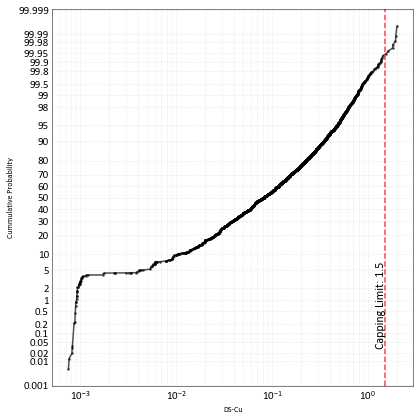

In [17]:
fig, ax = outlier.probplot(
    var,
    wts=wts,
    thresh=1.5,
    tukeys_fences=False,
    logx=True,
    figsize=(6, 6),
)
savefig(f"outlier_{example}_cpp")

Saving figure outlier_ex3_cpp_tukey


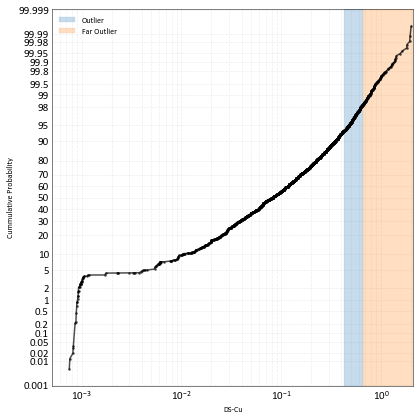

In [18]:
# with Tukey's Fences
fig, ax = outlier.probplot(
    var, wts=wts, thresh=None, tukeys_fences=True, logx=True, figsize=(6, 6),
)
savefig(f"outlier_{example}_cpp_tukey")

# Decile Analysis

- Decile analysis after Parrish (1997): "Geologist's Gordian Knot - To Cut Or Not To Cut"
- General recommendations are to check if:
    - The upper decile contains more than 40% of the total metal
    - The upper decile contains more than 2x the total metal of the previous decile
    - The upper percentile contains more than 10% of the total metal
- All decile and percentile statistics are weighted by assay length
- The lower threshold can be used to remove samples, for example samples at detection limit

In [19]:
decile = outlier.parrish_table(var, length)
display(decile)

,count,mean,std,min,25%,50%,75%,max,Metal,% Total
Decile,,,,,,,,,,
0,325,0.02,0.01,0.00,0.01,0.02,0.03,0.03,56.5,0.7
1,325,0.05,0.01,0.03,0.04,0.05,0.06,0.07,167.1,2.0
2,325,0.09,0.01,0.07,0.08,0.09,0.10,0.11,289.8,3.5
3,325,0.13,0.01,0.11,0.12,0.13,0.14,0.15,417.0,5.1
4,325,0.17,0.01,0.15,0.16,0.17,0.18,0.20,559.2,6.8
5,325,0.22,0.01,0.20,0.21,0.22,0.23,0.25,715.3,8.7
6,325,0.28,0.02,0.25,0.26,0.27,0.29,0.31,897.1,10.9
7,325,0.35,0.03,0.31,0.33,0.35,0.37,0.40,"1,139.4",13.9
8,325,0.47,0.04,0.40,0.43,0.47,0.51,0.55,"1,532.0",18.6


- export table to csv

In [20]:
decile.data.to_csv(f"./parrish_decile_{example}.csv")

- export table to latex

In [21]:
formats = ["{:,.0f}", *("{:.2f} " * 7).split(" ")[:-1], "{:,.1f}", "{:.1f}"]
format_dict = {
    col: fmt.format for (col, fmt) in zip(decile.data.columns, formats)
}
decile.data.to_latex(
    f"./parrish_decile_{example}.tex",
    formatters=format_dict,
    label=f"tab:parrish_{example}",
    caption="Parrish decile analysis for copper distribution.",
)

- calculating the decile table automatically sets the ```parrish_thresh``` attribute on the class

In [22]:
outlier.parrish_thresh

- an arbitrary threshold can be set and called at any time

In [23]:
outlier.set_threshold(1.0)
outlier.thresh

1.0

# Outlier Section Plots

- Simple inlier/outlier section plots based on a threshold

Saving figure outlier_ex3_xy


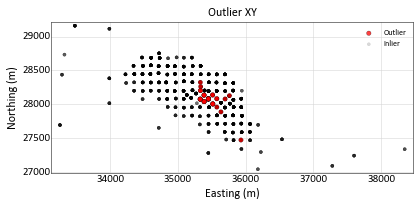

In [24]:
fig, ax = outlier.sectionplot(
    var,
    x="X",
    y="Y",
    z="Z",
    thresh=outlier.thresh,
    orient="xy",
    figsize=(6, 10),
    title="Outlier XY",
    pt_kws={"alpha": 0.15, "s": 10, "c": "k", "label": "Inlier"},
    out_kws={"alpha": 0.75, "s": 20, "ec": "k", "c": "r", "label": "Outlier"},
)
ax.legend()
savefig(f"outlier_{example}_xy")

Saving figure outlier_ex3_yz


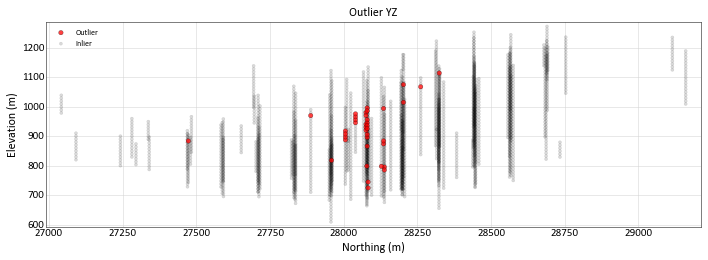

In [25]:
fig, ax = outlier.sectionplot(
    var,
    x="X",
    y="Y",
    z="Z",
    thresh=outlier.thresh,
    orient="yz",
    figsize=(10, 6),
    title="Outlier YZ",
)
savefig(f"outlier_{example}_yz")

# Cutting Curves

- Cutting curves after Roscoe (1996): "Cutting curves for grade estimation and grade control in gold mines."

Saving figure outlier_ex3_cutting_curve


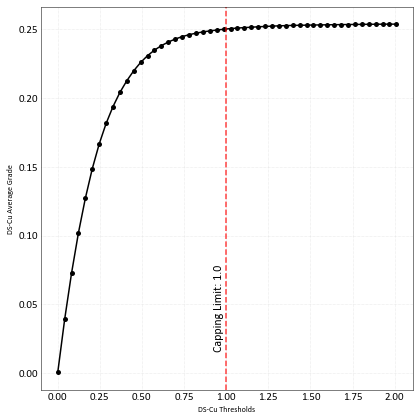

In [26]:
fig, ax = outlier.cutting_curve(
    var,
    num_thresh=50,
    plot_thresh=outlier.thresh,
    logx=False,
    figsize=(6, 6),
    marker=".",
    ms=10,
    c="k",
)
savefig(f"outlier_{example}_cutting_curve")

# Cumulative Coefficient of Variation
- Cumulative Coefficient of Variation after Parker (1991): "Statistical Treatment of Outlier Data in Epithermal Gold Deposit Reserve Estimation"
- The cumulative CV can be plotted and used to identify quantiles where there is a sudden acceleration in cumulative CV; this is where the influence of the outliers in the upper tail becomes strong.

In [27]:
ccv = outlier.cumcv(var, length)
ccv

,DS-Cu,length,grade_x_length,cum_mean,cum_std,cum_cv,cum_metal
0,2.009710,10.0,20.097100,0.253279,0.229012,0.904188,0.244523
1,1.959210,10.0,19.592100,0.252738,0.226960,0.898008,0.482901
2,1.942650,10.0,19.426500,0.252211,0.225008,0.892139,0.719265
3,1.820000,10.0,18.200000,0.251690,0.223074,0.886305,0.940706
4,1.813800,10.0,18.138000,0.251206,0.221400,0.881349,1.161392
...,...,...,...,...,...,...,...
3240,0.000825,10.0,0.008246,0.000794,0.000036,0.045039,99.999617
3241,0.000820,10.0,0.008200,0.000786,0.000036,0.046050,99.999717
3242,0.000815,10.0,0.008145,0.000775,0.000035,0.044758,99.999816
3243,0.000760,10.0,0.007602,0.000755,0.000007,0.009510,99.999909


Saving figure outlier_ex3_cumcv


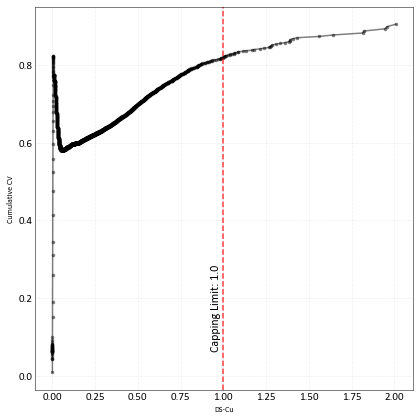

In [28]:
fig, ax = outlier.cumcv_plot(
    var, length, plot_thresh=outlier.thresh, figsize=(6, 6), marker=".", alpha=0.5, c="k"
)
savefig(f"outlier_{example}_cumcv")

# Mean Uncertainty

- Nowak et al. (2013): "SUGGESTIONS FOR GOOD GRADE CAPPING PRACTICES FROM HISTORICAL LITERATURE"
- Assess mean uncertainty using the spatial bootstrap
- A percentile of the data (```perc_to_cap```) can be omitted from the bootstrapping (potential capping candidates) to observe how removing data influences the expected mean versus the uncapped true mean
- The point of this exercise is an assessment of what could be an optimistic average grade in a domain if the highest ```perc_to_cap```% of the values are not used.
- If the uncapped average grade is much greater than the expected average grade after removing samples, capping may be warranted
- The variogram model for bootstrapping should be of the normal scores

In [29]:
vargstr = """  2       0.11394    -nst, nugget effect
  1       0.55980     135.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        246.32403        353.83079        353.83079    -a_hmax, a_hmin, a_vert (ranges)
  1       0.32626     135.00000       0.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
       1017.49924        707.66158        707.66158    -a_hmax, a_hmin, a_vert (ranges)"""

Saving figure outlier_ex3_mean_uncert


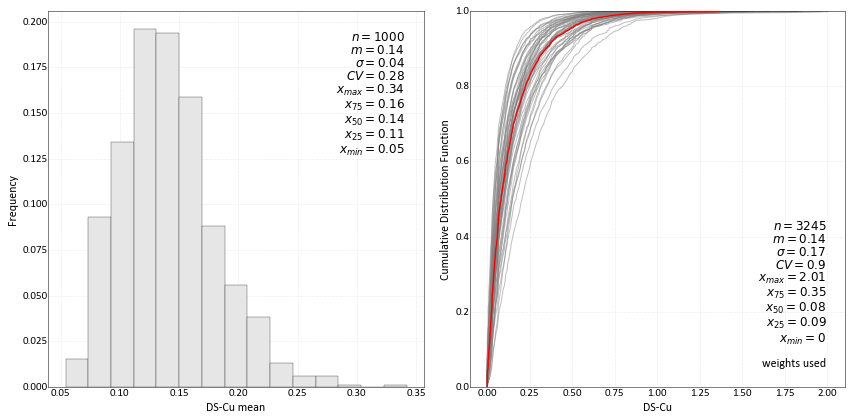

In [30]:
fig, ax = outlier.mean_uncertainty(
    var,
    wts=wts,
    vargstr=vargstr,
    perc_to_cap=0,
    seed=98742,
    nreals=1000,
    reals_to_plot=50,
    logx=False,
    figsize=(12, 6),
)
savefig(f"outlier_{example}_mean_uncert")

# Metal at Risk

- Metal at risk described by Parker (2006): "Technical Report of the Rock Creek Property, Nome, Alaska, USA" (pg. 17-18)
- Resample the assay distribution considering the number of assays (```nsamples```) available in a given production volume
    - typically ```nsamples``` is equal to tonnes per annual production volume / number of tonnes per assay in the domain
    - metal at risk accounts for the data density - as ```nsamples``` increases, metal at risk decreases
- Risk adjusted metal is the total metal below ```thresh``` plus P20 of the boostrapped metal above ```thresh```
- Metal at risk is the difference between the total expected metal and metal at risk 

In [31]:
risk = outlier.metal_at_risk(
    var,
    wts=wts,
    nsamples=500,
    thresh=outlier.thresh,
    seed=987654,
    nreals=1000,
)

In [32]:
risk

{'Number of Samples': 500,
 'HG Threshold': 1.0,
 'Expected HG Samples': 2,
 'Metal at Risk %': 6.66}

In [33]:
pd.DataFrame.from_dict(risk, orient="index").T.to_latex(
    f"./metal_at_risk_{example}.tex",
    label=f"tab:MAR_{example}",
    caption="Metal at risk for a porphyry copper distribution.",
    index=False,
)

# Metal Removed by Capping

Saving figure outlier_ex3_metal_removed


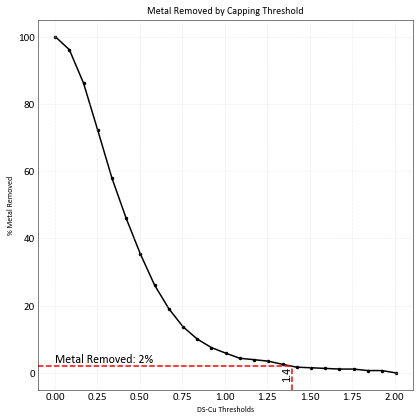

In [34]:
fig, ax = outlier.metal_removed(
    var,
    length,
    num_thresh=25,
    p=2,
    marker=".",
    c="k",
    line_kws={"colors": "r", "linestyles": "--"},
    title="Metal Removed by Capping Threshold",
    figsize=(6, 6),
)
savefig(f"outlier_{example}_metal_removed")